# Using OJA data to estimate GDP components

## Loading data and useful functions

This notebook runs on R version 3.6.3. It is __important__ not to use R 4., because some packages are not available anymore. 
This Notebook presents an example of usage of OJA data to try and estimate 2 time series that are used in the Slovenian calculation of the GDP. The target data consists of 38 monthly values for the VAT of Turnover from the sale of services and the Index of Turnover from the sale of services. They are estimated using number of OJA acquired from Slovene job portals MojeDelo and MojaZaposlitev, which are scraped weekly at our office. Unfortunately, we don't have permission to publish the VAT series, however the below process can easily be widened to that data as well.

For a comprehensive analysis document see [in this document on the Slovenian Report GitHub page](https://github.com/OnlineJobVacanciesESSnetBigData/Reports/tree/master/SI)

Firstly, we will (install and) load the required packages:

In [1]:
# install.packages(c("dplyr", "data.table", "lubridate", "TSA", "tseries", "forecasts"))

suppressMessages(c(library(dplyr),
                   library(data.table),
                   library(lubridate),
                   library(TSA),
                   library(tseries),
                   library(forecast),
                   library(IRdisplay)))

[1] "dplyr"      "stats"      "graphics"   "grDevices"  "utils"     
 [6] "datasets"   "methods"    "base"       "data.table" "dplyr"     
[11] "stats"      "graphics"   "grDevices"  "utils"      "datasets"  
[16] "methods"    "base"       "lubridate"  "data.table" "dplyr"     
[21] "stats"      "graphics"   "grDevices"  "utils"      "datasets"  
[26] "methods"    "base"       "TSA"        "lubridate"  "data.table"
[31] "dplyr"      "stats"      "graphics"   "grDevices"  "utils"     
[36] "datasets"   "methods"    "base"       "tseries"    "TSA"       
[41] "lubridate"  "data.table" "dplyr"      "stats"      "graphics"  
[46] "grDevices"  "utils"      "datasets"   "methods"    "base"      
[51] "forecast"   "tseries"    "TSA"        "lubridate"  "data.table"
[56] "dplyr"      "stats"      "graphics"   "grDevices"  "utils"     
[61] "datasets"   "methods"    "base"       "IRdisplay"  "forecast"  
[66] "tseries"    "TSA"        "lubridate"  "data.table" "dplyr"     
[71] "stats"      "graphics"   "grDevices"  "utils"      "datasets"  
[76] "methods"    "base"

Next, we load all data. Since we do not have a lot of data, our training and test sets will be quite small. Job portal data are scraped into one file each week, we will have to load them all. Additionally, the scraping process changed in the middle of 2018, and are stored separately. Additionaly, until 2018 the scraping process was not yet fully developed, therefore multiple scrapes might have happened on some weeks. Later we will average this data  from daily points into monthly data.

Sale of services is saved into the file `Sales_of_services_2017_05_2020_02.csv` and is delimited with semicommas. We will also rename the rows by using the first column. We have decided that the split should happen between 2019M12 and 2020M01.

In [2]:
work_m <- read.csv2(file="Sales_of_services_2017_05_2020_02.csv")
names_w <- sub("-", "M", substring(ymd(paste(work_m$YearMonth, "_01", sep="")), 1, 7))
work_m <- work_m[apply(work_m, 1, function(x) all(!is.na(x))), -1]
names(work_m) <- names_w

work_est <- work_m[which(names(work_m) == "2020M01"):length(work_m)]
work_m <- work_m[1:which(names(work_m) == "2019M12")]

We have two job portals and each of them is saved in two subfolders (due to the change in scraping in 2018). The formats and variables also change, therefore some formatting needs to be done, specifically the dates need to be in the same format. 

In [3]:
# OJA agencies - current scraping
MD <- "./JobPortals/MOJEDELO/Python-scraped"
MZ <- "./JobPortals/MOJAZAPOSLITEV/Python-scraped"

# OJA agencies - old scraping
MD_dss <- "./JobPortals/MOJEDELO/DSS"
MZ_dss <- "./JobPortals/MOJAZAPOSLITEV/DSS"

# Loading current scraping type data and naming rows by scrape date
JAs_MD <- sapply(list.files(MD), function(filename) nrow(fread(file.path(MD, filename), select = 1L)))
names(JAs_MD) <- sapply(names(JAs_MD), function(name) substring(name, 17, 26))

JAs_MZ <- sapply(list.files(MZ), function(filename) nrow(fread(file.path(MZ, filename), select = 1L)))
names(JAs_MZ) <- sapply(names(JAs_MZ), function(name) substring(name, 23, 32))

Loading previous scraping type data and naming rows by scrape date. We are only interested in the number of OJA in each scrape period, which is obtained by counting the number of rows. The date formats are different in the data, we catch them with regex. **Some date formats might not be present and this will result in warnings. We ignore them.**

In this code we use `quote=""`, since some variables use quoted text in their strings.

In [4]:
JAs_MD2 <- sapply(list.files(MD_dss), function(filename) 
    nrow(fread(file.path(MD_dss, filename), select = 1L, quote=""))) 
names <- ymd(regmatches(names(JAs_MD2), regexpr("\\d+-\\d+-\\d+", names(JAs_MD2))))
names[is.na(names)] <- ymd(dmy(regmatches(names(JAs_MD2), regexpr("\\d+-\\d+-\\d+", names(JAs_MD2)))))[
   !is.na(ymd(dmy(regmatches(names(JAs_MD2), regexpr("\\d+-\\d+-\\d+", names(JAs_MD2))))))]
names(JAs_MD2) <- names

JAs_MZ2 <- sapply(list.files(MZ_dss), 
                  function(filename) nrow(fread(file.path(MZ_dss, filename), select = 1L, quote="")))
names <- ymd(regmatches(names(JAs_MZ2), regexpr("\\d+-\\d+-\\d+", names(JAs_MZ2))))
names[is.na(names)] <- ymd(dmy(regmatches(names(JAs_MZ2), regexpr("\\d+-\\d+-\\d+", names(JAs_MZ2)))))[
   !is.na(ymd(dmy(regmatches(names(JAs_MZ2), regexpr("\\d+-\\d+-\\d+", names(JAs_MZ2))))))]
names(JAs_MZ2) <- names

Warning message:
"All formats failed to parse. No formats found."
Warning message:
"All formats failed to parse. No formats found."
Warning message:
"All formats failed to parse. No formats found."
Warning message:
"All formats failed to parse. No formats found."


Finally, we define two functions that will help us normalize and de-normalize the data series to be used on the same graphs. The normalization is done onto the interval _[-1, 1]_, and is only effected on present data series elements (it excludes NA values). 

The functions can also be used to transform other values to the same scale. The function *front_fun* has an optional parameter _tsd_ which will be used for such transformations. This paracter is required in the function *reverse_fun*.

In [5]:
display_latex("$$front\\_ fun(x_n, T_n)=\\frac{2x_n - \\min \\left[T_n;T_n\\neq NA\\right] - \\max \\left[T_n;T_n\\neq NA\\right]}{\\max \\left[T_n;T_n\\neq NA\\right] - \\min \\left[T_n;T_n\\neq NA\\right]}$$")
cat("\n")
display_latex("$$reverse\\_fun(y_n, T_n) = \\frac{\\left(y_n + 1\\right)\\max\\left[T_n;T_n\\neq NA\\right] -  \\left(y_n - 1\\right)\\min\\left[T_n;T_n\\neq NA\\right]}{2}$$")

In [6]:
# Normalize to -1, 1 and reverse
front_fun <- function(xx, tsd=NULL) {
   if(is.null(tsd)) tsd <- xx
   return((2*xx - min(tsd[!is.na(tsd)]) - max(tsd[!is.na(tsd)]))/(max(tsd[!is.na(tsd)])-min(tsd[!is.na(tsd)])))
   }
reverse_fun <- function(yy, tsd) ((yy + 1)*max(tsd[!is.na(tsd)]) - (yy-1)*min(tsd[!is.na(tsd)]))/2

## Transforming and analyzing data

### _TIME SERIES - monthly sums by week averages_

We combine data from both agencies by summing weekly averages every month. This is done, because the number of actual scrapings is inconsitent some periods (as we were still developing the process of scraping). 

This is done for both type of scraping, and the datasets are then concatenated to form a single dataset with datapoints from 2017 to 2020.

In [7]:
# Monthly averages
dates <- sort(union(names(JAs_MD), names(JAs_MZ)))
JAs_early <- tibble(JAs_MD = JAs_MD2[names(JAs_MZ2)], JAs_MZ = JAs_MZ2, date=as.Date(names(JAs_MZ2)))
JAs <- tibble(JAs_MD=JAs_MD[dates], JAs_MZ=JAs_MZ[dates], date=as.Date(dates))

Monthly_avg_early <- JAs_early %>% group_by(month=floor_date(date, "month")) %>%
   summarize(mJAs_MD=mean(JAs_MD[!is.na(JAs_MD)]), mJAs_MZ=mean(JAs_MZ[!is.na(JAs_MZ)]))
Monthly_avg_early$mJAs <- apply((Monthly_avg_early %>% select(-month)), 1, sum)
Monthly_avg_early <- data.frame(Monthly_avg_early)
rownames(Monthly_avg_early) <- sub("-", "M", substring(as.character(Monthly_avg_early$month), 1, 7))

Monthly_avg <- JAs %>% group_by(month=floor_date(date, "month")) %>% 
   summarize(mJAs_MD=mean(JAs_MD[!is.na(JAs_MD)]), mJAs_MZ=mean(JAs_MZ[!is.na(JAs_MZ)]))
Monthly_avg$mJAs <- apply((Monthly_avg %>% select(-month)), 1, sum)
Monthly_avg <- data.frame(Monthly_avg)
rownames(Monthly_avg) <- sub("-", "M", substring(as.character(Monthly_avg$month), 1, 7))

JAs_monthly_avg = rbind(Monthly_avg_early, Monthly_avg)[,-1]
JAs_monthly_avg_true <- data.frame(apply(JAs_monthly_avg, 2, function(x) front_fun(x, x)))
points <- c(1, rep(NA, nrow(Monthly_avg_early) - 2), nrow(Monthly_avg_early), nrow(Monthly_avg_early) + 1,
            rep(NA, nrow(JAs_monthly_avg_true) - nrow(Monthly_avg_early) - 2), nrow(JAs_monthly_avg_true))


`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



We also prepare daily data of the OJAs to be used in the graphs.

**1.** JAs_daily: a matrix with collected number of scraped articles for each day.

**2.** JAs_daily_true: a matrix with collected _normalized_ number of scraped articles for each day.

**3.** daily_seq: the vector of every day in the whole period 2017M01-2020M02.

**4.** Daily_JAs: a matrix with daily OJA data; filled wih NA where no scraping occurred.


In [8]:
# Daily data
Daily_early <- JAs_early %>% group_by(date=floor_date(date, "day")) %>% 
   summarize(dJAs_MD=max(JAs_MD), dJAs_MZ=max(JAs_MZ))
Daily_early$dJAs <-  apply((Daily_early %>% select(-date)), 1, sum)
Daily_early <- data.frame(Daily_early)
rownames(Daily_early) <- as.Date(Daily_early$date)
Daily <- JAs %>% group_by(date=floor_date(date, "day")) %>% 
   summarize(dJAs_MD=max(JAs_MD), dJAs_MZ=max(JAs_MZ))
Daily$dJAs <-  apply((Daily %>% select(-date)), 1, sum)
Daily <- data.frame(Daily)
rownames(Daily) <- as.Date(Daily$date)
JAs_daily <- rbind(Daily_early, Daily)[,-1]
JAs_daily_true <- data.frame(apply(JAs_daily, 2, function(x) front_fun(x, x)))

daily_seq <- seq(as.Date("2017-01-01"), 
                 as.Date(paste(sub("M", "-", last(rownames(JAs_daily))), "-01", sep="")) %m+% months(1), "day")
Daily_JAs <- JAs_daily[as.character(daily_seq),]
rownames(Daily_JAs) <- daily_seq

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



### _Graphs - Monthly Sale of services data vs Daily OJA data_

We will be plotting graphs to more easily analyze our data. The target data (Indices of Turnovers of the Sale of services) are plotted with rectangles representing months, while OJA data are superimposed on it. We additionaly plot the period where loss of data occurred with a pink area and grey dashes on the OJA data. The abcise will represent time in days, the ordinate will be represent all data values. The left side of the graph will measure the target data, while the right side will measure all three OJA datasets.

First we create date vectors representing the points where dashed lines should be drawn.

In [9]:
# Grey dashes in data loss periods
Loss_JAs <- as.Date(rownames(JAs_daily_true)[
    !is.na(JAs_daily_true$dJAs) &  as.Date("2017-12-01") <= as.Date(rownames(JAs_daily_true)) &  
    as.Date(rownames(JAs_daily_true)) <= as.Date("2018-02-13")
])
Loss_JAs_MD <- as.Date(rownames(JAs_daily_true)[
    !is.na(JAs_daily_true$dJAs_MD) &  as.Date("2017-12-01") <= as.Date(rownames(JAs_daily_true)) &  
    as.Date(rownames(JAs_daily_true)) <= as.Date("2018-02-13")
])
Loss_JAs_MZ <- as.Date(rownames(JAs_daily_true)[
    !is.na(JAs_daily_true$dJAs_MZ) &  as.Date("2017-12-01") <= as.Date(rownames(JAs_daily_true)) &  
    as.Date(rownames(JAs_daily_true)) <= as.Date("2018-02-13")
])


Then we draw the actaul graph.

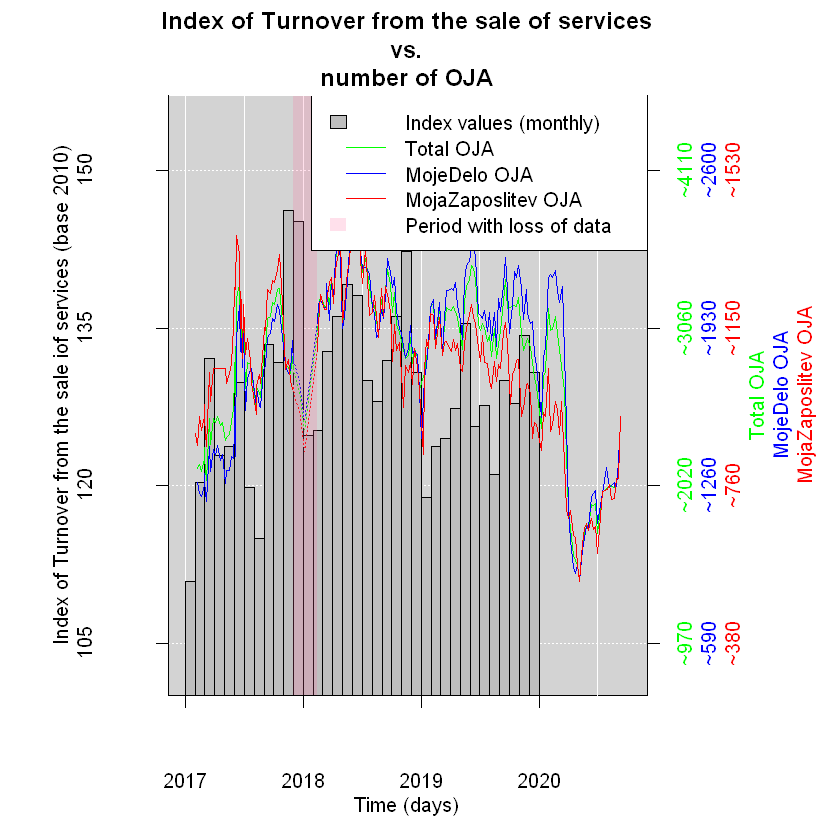

In [10]:
# Options for placement of marks and titles
par(mar = c(6, 7, 4, 8), mgp=c(4,3,0))

# Indices
plot(daily_seq, 1:length(daily_seq), type="n", ylim=c(-1.5, 1.5), yaxt="n", ylab="", 
     xlab="Time (days)", main="Index of Turnover from the sale of services\nvs.\nnumber of OJA")
rect(par("usr")[1], par("usr")[3], par("usr")[2], par("usr")[4], col="lightgrey")
abline(v=daily_seq[which(daily_seq %in% as.Date(paste(2017:2020, "-01-01", sep="")))], col="white")
abline(v=daily_seq[which(daily_seq %in% as.Date(paste(2017:2020, "-07-01", sep="")))], col="white")
abline(h=front_fun(seq(90, 165, 15), work_m), col="white", lty=3)
rect(daily_seq[mday(daily_seq)==1][1:length(work_m)], rep(par("usr")[3], length(work_m)), 
     (daily_seq[mday(daily_seq)==1])[1:length(work_m)+1], front_fun(work_m, work_m), 
     col=rep("gray", length(work_m)), border=rep("black", length(work_m)))
lines(as.Date(rownames(JAs_daily_true)[!is.na(JAs_daily_true$dJAs)]), 
      JAs_daily_true$dJAs[!is.na(JAs_daily_true$dJAs)], col="green")
lines(as.Date(rownames(JAs_daily_true)[!is.na(JAs_daily_true$dJAs_MD)]), 
      JAs_daily_true$dJAs_MD[!is.na(JAs_daily_true$dJAs_MD)], col="blue")
lines(as.Date(rownames(JAs_daily_true)[!is.na(JAs_daily_true$dJAs_MZ)]), 
      JAs_daily_true$dJAs_MZ[!is.na(JAs_daily_true$dJAs_MZ)], col="red")
axis(4, at=front_fun(seq(90, 165, 15), work_m), 
     labels=paste("~", round(reverse_fun(front_fun(seq(90, 165, 15), work_m), Daily$dJAs)/10)*10, "\n\n", sep=""),
     col.axis="green")
axis(4, at=front_fun(seq(90, 165, 15), work_m), 
     labels=paste("\n~", round(reverse_fun(front_fun(seq(90, 165, 15), work_m), Daily$dJAs_MD)/10)*10, "\n", sep=""),
     col.axis="blue")
axis(4, at=front_fun(seq(90, 165, 15), work_m), 
     labels=paste("\n\n~", round(reverse_fun(front_fun(seq(90, 165, 15), work_m), Daily$dJAs_MZ)/10)*10, sep=""),
     col.axis="red")
mtext(text=c("Total OJA\n\n", "\nMojeDelo OJA\n", "\n\nMojaZaposlitev OJA"),
      side=4, line=6, col=c("green", "blue", "red"))
axis(2, at=front_fun(seq(90, 165, 15), work_m), labels=paste("\r", seq(90, 165, 15), sep=""), col.axis="black")
mtext(text="Index of Turnover from the sale iof services (base 2010)", side=2, line=4)
# Grey dashes in data loss periods
lines(Loss_JAs, JAs_daily_true$dJAs[which(as.Date(rownames(JAs_daily_true)) %in% Loss_JAs)], col="grey", lty=3)
lines(Loss_JAs_MD, JAs_daily_true$dJAs_MD[which(as.Date(rownames(JAs_daily_true)) 
                                                %in% Loss_JAs_MD)], col="grey", lty=3)
lines(Loss_JAs_MZ, JAs_daily_true$dJAs_MZ[which(as.Date(rownames(JAs_daily_true)) 
                                                %in% Loss_JAs_MZ)], col="grey", lty=3)
rect(as.Date(Loss_JAs[1]), par("usr")[3], as.Date(last(Loss_JAs)), 
     par("usr")[4], col= rgb(1,0.4,0.6,alpha=0.2), border=NA)
# Legend
legend("topright", c("Index values (monthly)", "Total OJA", "MojeDelo OJA",
                     "MojaZaposlitev OJA", "Period with loss of data"), 
       fill=c("grey", NA, NA, NA, rgb(1,0.4,0.6,alpha=0.2)), col=c(NA, "green", "blue", "red", NA),
       lwd=c(NA, 1, 1, 1), border=c("black", NA, NA, NA, NA), cex=1)


### _Analyses and forecasts_

Our data analysis consists of correlations, linear regression, the ACF and PACF, Ljung-Box and ADF tests and ARIMA estimation. 

_**Note:**_ the first month (2017M01) is not useful to our work, since only one date is scraped for MZ and is uncharacteristically low, and no dates are scraped for MD. We skip that datepoint hereafter.

Correlations:

mJAs_MD   mJAs_MZ      mJAs 
0.3430750 0.2378156 0.3368550


-------------------------------
Linear regressions
Indices
Call:
lm(formula = c ~ r, data = estimation_Data)

Residuals:
    Min      1Q  Median      3Q     Max 
-12.448  -4.054  -1.101   3.652  17.356 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.119e+02  8.605e+00  13.005 1.54e-14 ***
r           9.473e-03  4.515e-03   2.098   0.0436 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 6.984 on 33 degrees of freedom
Multiple R-squared:  0.1177,	Adjusted R-squared:  0.09096 
F-statistic: 4.402 on 1 and 33 DF,  p-value: 0.04363

Indices linreg RMSE:

[1] 6.781739

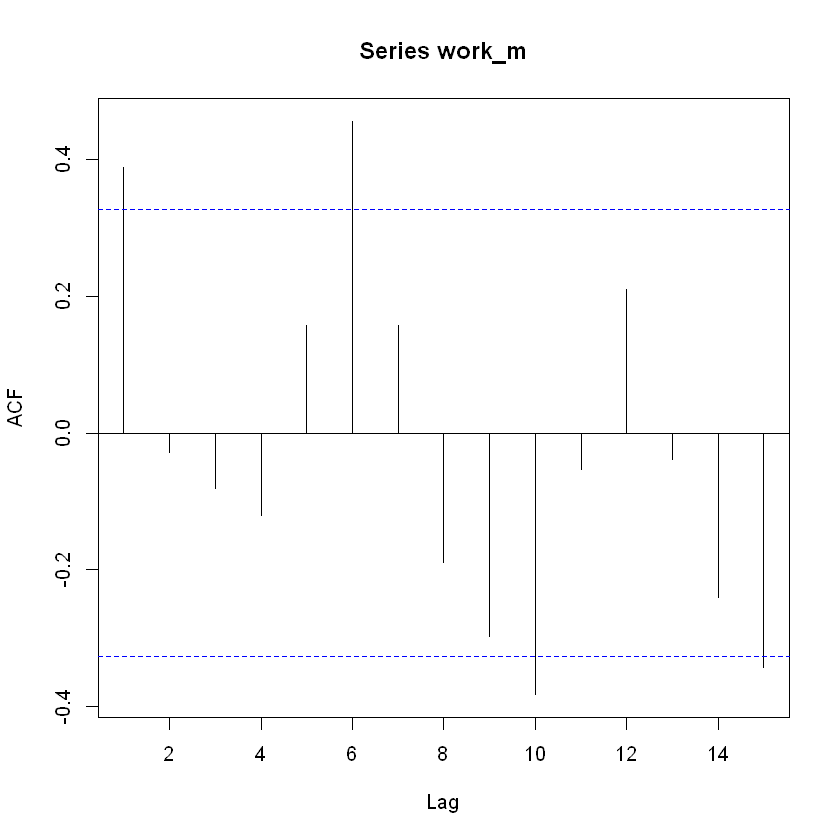

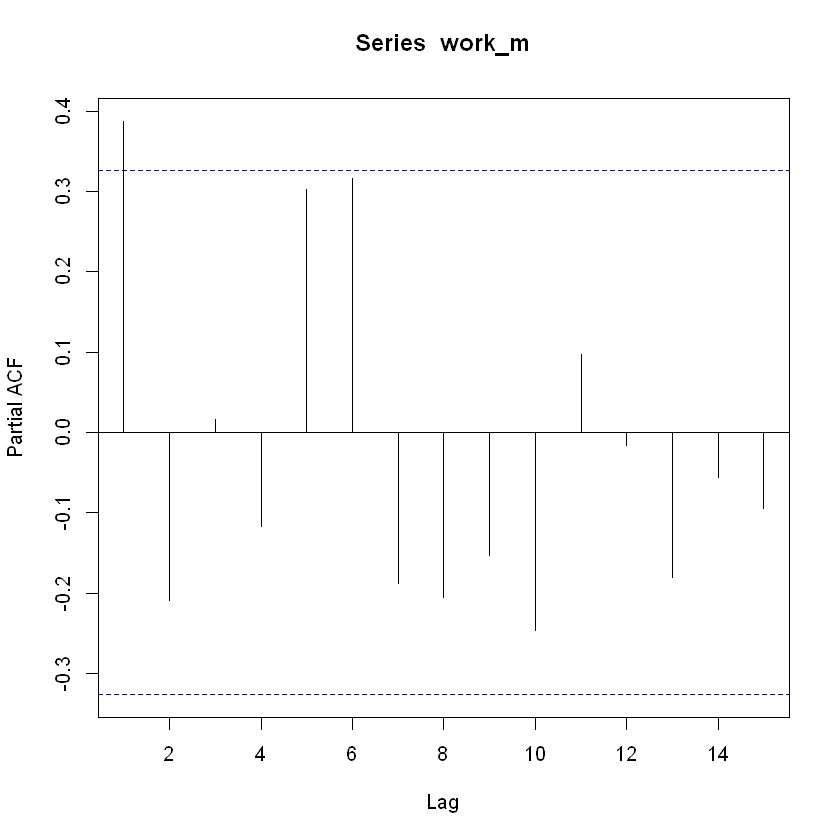

In [11]:
# Correlations
cat("Correlations:")
(cor_indices <- apply(JAs_monthly_avg[2:length(work_m),], 2, function(x) cor(x, work_m[-1])))

# Linear regression - Indices
cat("\n-------------------------------")
cat("\nLinear regressions")
cat("\nIndices")
estimation_Data <- data.frame(c=work_m[-1], r=JAs_monthly_avg$mJAs_MD[2:length(work_m)])
mm_indices <- lm(c~r, estimation_Data)
print(summary(mm_indices))
ests_indices <- predict(mm_indices, data.frame(r=JAs_monthly_avg$mJAs_MD[(length(work_m)+1):length(JAs_monthly_avg)]))
# RMSE - Indices
cat("Indices linreg RMSE:")
(RMSE_indices <- sqrt(mean((work_m[-1]-predict(mm_indices))^2)))
# Forecast - Indices
ests_low <- front_fun(ests_indices - RMSE_indices , work_m)
ests_g <- front_fun(ests_indices, work_m)
ests_high <- front_fun(ests_indices + RMSE_indices, work_m)


# ARIMAX model
acf(work_m)
pacf(work_m)
best_arima <- auto.arima(work_m)  # Selects MA(1), AIC=242.01, LL=-117.62
ljungb <- Box.test(as.ts(work_m), lag=1, type="Ljung-Box") # T statistic: 0.01755
adftest <- adf.test(as.ts(work_m), alternative="stationary")
# AIC=222.07, LL=-108.03
marimax <- arimax(work_m[-1], order=c(0, 0, 1), xreg=JAs_monthly_avg$mJAs_MD[2:length(work_m)]) 
arimax_est <- predict(marimax, newxreg=JAs_monthly_avg$mJAs_MD[(length(work_m)+1):length(JAs_monthly_avg)])
# Forecasts
arimax_low <- front_fun(arimax_est$pred - sqrt(arimax_est$se[1])*1.96, work_m)
arimax_g <- front_fun(arimax_est$pred, work_m)
arimax_high <- front_fun(arimax_est$pred + sqrt(arimax_est$se[1])*1.96, work_m)


#### Forecasts graphs

We create a similar graph to the above ones, but with estimations and only using one OJA series.

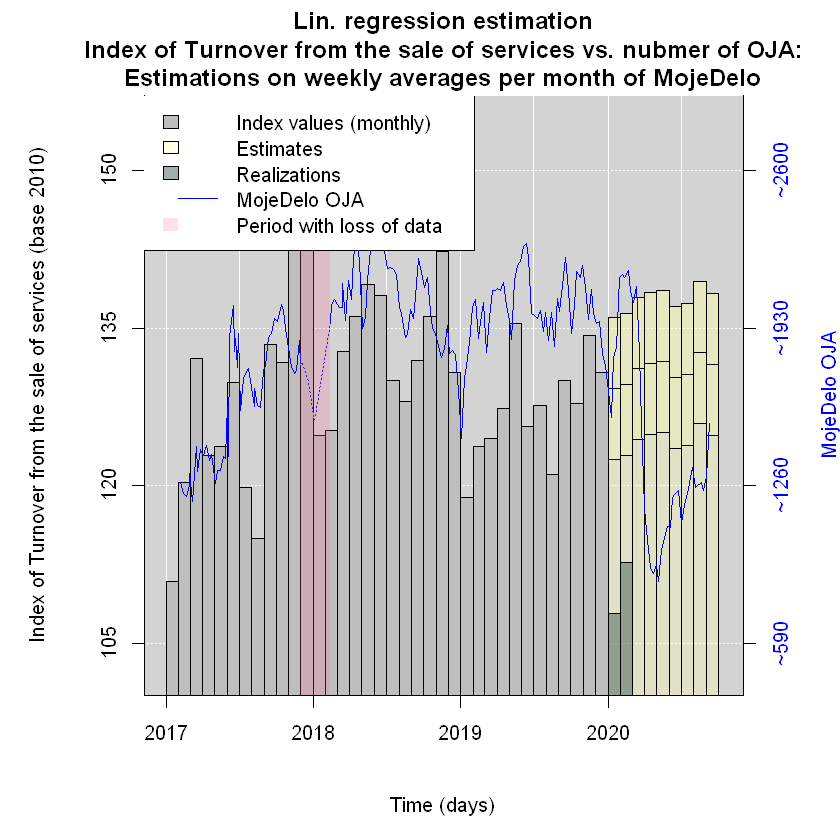

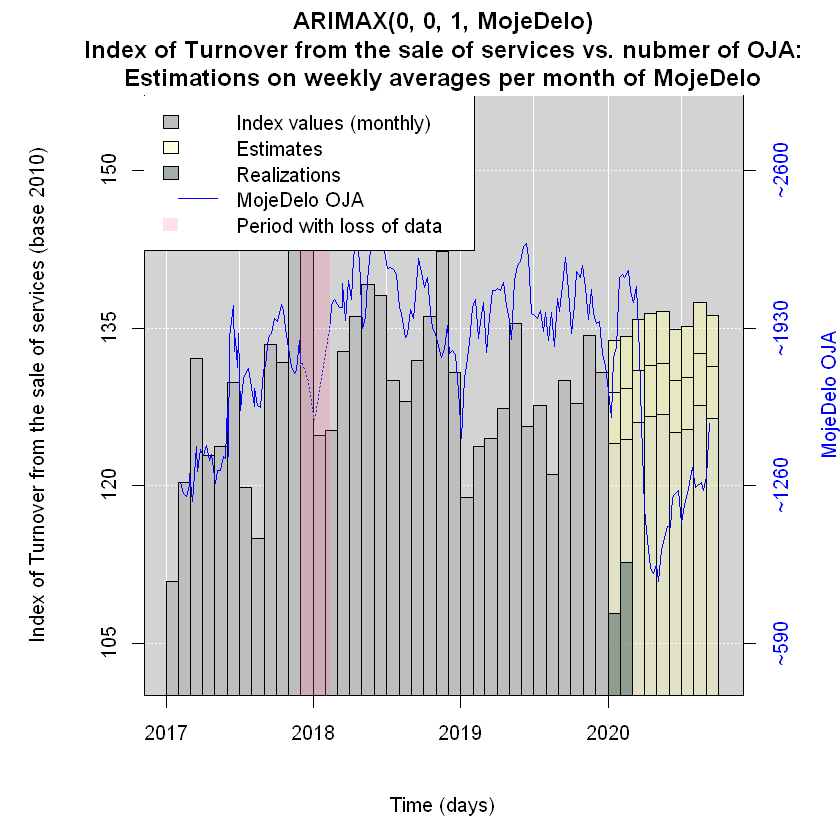

In [12]:
# Options for placement of marks and titles
par(mar = c(6, 6, 4, 4), mgp=c(4,1,0))

# Forecast graph
# Linear regression
plot(daily_seq, 1:length(daily_seq), type="n", ylim=c(-1.5, 1.5), yaxt="n", ylab="", 
     xlab="Time (days)", main=paste0("Lin. regression estimation\nIndex of Turnover from the sale of",
                                     " services vs. nubmer of OJA:\nEstimations on weekly averages per",
                                     " month of MojeDelo"))
rect(par("usr")[1], par("usr")[3], par("usr")[2], par("usr")[4], col="lightgrey")
abline(v=daily_seq[which(daily_seq %in% as.Date(paste(2017:2020, "-01-01", sep="")))], col="white")
abline(v=daily_seq[which(daily_seq %in% as.Date(paste(2017:2020, "-07-01", sep="")))], col="white")
abline(h=front_fun(seq(90, 165, 15), work_m), col="white", lty=3)
rect(daily_seq[mday(daily_seq)==1][1:length(work_m)], rep(par("usr")[3], length(work_m)), 
     (daily_seq[mday(daily_seq)==1])[1:length(work_m)+1], front_fun(work_m, work_m),
     col=rep("gray", length(work_m)), border=rep("black", length(work_m)))

axis(4, at=front_fun(seq(90, 165, 15), work_m), 
     labels=paste("~", round(reverse_fun(front_fun(seq(90, 165, 15), work_m), Daily$dJAs_MD)/10)*10, sep=""),
     col.axis="blue")
mtext(text="MojeDelo OJA", side=4, line=3, col="blue")
axis(2, at=front_fun(seq(90, 165, 15), work_m), labels=paste("\r", seq(90, 165, 15), sep=""), col.axis="black")
mtext(text="Index of Turnover from the sale of services (base 2010)", side=2, line=4)

# Forecasts
rect(daily_seq[mday(daily_seq)==1][(1+length(work_m)):(length(work_m)+length(ests_indices))], ests_low,
     (daily_seq[mday(daily_seq)==1])[(2+length(work_m)):(length(work_m)+1+length(ests_indices))], ests_g,
     col="#FFFFAA75", border=rep("black", length(work_m)))
rect(daily_seq[mday(daily_seq)==1][(1+length(work_m)):(length(work_m)+length(ests_indices))], ests_g,
     (daily_seq[mday(daily_seq)==1])[(2+length(work_m)):(length(work_m)+1+length(ests_indices))], ests_high,
     col="#FFFFAA75", border=rep("black", length(work_m)))
rect(daily_seq[mday(daily_seq)==1][(1+length(work_m)):(length(work_m)+length(ests_indices))], 
     rep(par("usr")[3], length(ests_indices)),
     (daily_seq[mday(daily_seq)==1])[(length(work_m)+2):(length(work_m)+1+length(ests_indices))], ests_low,
     col="#FFFFAA50", border=rep("black", length(work_m)))

# Series of scraped OJA
lines(as.Date(rownames(JAs_daily_true)[!is.na(JAs_daily_true$dJAs_MD)]), 
      JAs_daily_true$dJAs_MD[!is.na(JAs_daily_true$dJAs_MD)], col="blue")
lines(Loss_JAs_MD, JAs_daily_true$dJAs_MD[which(as.Date(rownames(JAs_daily_true)) %in% Loss_JAs_MD)], 
      col="grey", lty=3)
rect(as.Date(Loss_JAs[1]), par("usr")[3], as.Date(last(Loss_JAs)), par("usr")[4], 
     col= rgb(1,0.4,0.6,alpha=0.2), border=NA)
# Realni podatki
rect(daily_seq[mday(daily_seq)==1][(1+length(work_m)):(length(work_m)+length(work_est))], 
     rep(par("usr")[3], length(work_est)),
     (daily_seq[mday(daily_seq)==1])[(2+length(work_m)):(length(work_m)+1+length(work_est))], 
     front_fun(work_est, work_m),
     col="#2F4F4F75", border=rep("black", length(work_est)))

legend("topleft", c("Index values (monthly)", "Estimates", "Realizations", 
                    "MojeDelo OJA", "Period with loss of data"),
       fill=c("grey","#FFFFAA50", "#2F4F4F75", NA, rgb(1,0.4,0.6,alpha=0.2)),
       col=c(NA, NA, NA, "blue", NA), lwd=c(NA, NA, NA, 1, NA), border=c("black", "black", "black", NA, NA), cex=1)



# ARIMAX
plot(daily_seq, 1:length(daily_seq), type="n", ylim=c(-1.5, 1.5), yaxt="n", ylab="", 
     xlab="Time (days)", main=paste0("ARIMAX(0, 0, 1, MojeDelo)\nIndex of Turnover from the sale of",
                                     " services vs. nubmer of OJA:\nEstimations on weekly averages",
                                     " per month of MojeDelo"))
rect(par("usr")[1], par("usr")[3], par("usr")[2], par("usr")[4], col="lightgrey")
abline(v=daily_seq[which(daily_seq %in% as.Date(paste(2017:2020, "-01-01", sep="")))], col="white")
abline(v=daily_seq[which(daily_seq %in% as.Date(paste(2017:2020, "-07-01", sep="")))], col="white")
abline(h=front_fun(seq(90, 165, 15), work_m), col="white", lty=3)
rect(daily_seq[mday(daily_seq)==1][1:length(work_m)], rep(par("usr")[3], length(work_m)), 
     (daily_seq[mday(daily_seq)==1])[1:length(work_m)+1], front_fun(work_m, work_m),
     col=rep("gray", length(work_m)), border=rep("black", length(work_m)))

axis(4, at=front_fun(seq(90, 165, 15), work_m), 
     labels=paste("~", round(reverse_fun(front_fun(seq(90, 165, 15), work_m), 
                                         Daily$dJAs_MD)/10)*10, sep=""), col.axis="blue")
mtext(text="MojeDelo OJA", side=4, line=3, col="blue")

axis(2, at=front_fun(seq(90, 165, 15), work_m), labels=paste("\r", seq(90, 165, 15), sep=""), col.axis="black")
mtext(text="Index of Turnover from the sale of services (base 2010)", side=2, line=4)

# Forecasts
rect(daily_seq[mday(daily_seq)==1][(1+length(work_m)):(length(work_m)+length(arimax_est$pred))], arimax_low,
     (daily_seq[mday(daily_seq)==1])[(2+length(work_m)):(length(work_m)+1+length(arimax_est$pred))], arimax_g,
     col="#FFFFAA75", border=rep("black", length(work_m)))
rect(daily_seq[mday(daily_seq)==1][(1+length(work_m)):(length(work_m)+length(arimax_est$pred))], arimax_g,
     (daily_seq[mday(daily_seq)==1])[(2+length(work_m)):(length(work_m)+1+length(arimax_est$pred))], arimax_high,
     col="#FFFFAA75", border=rep("black", length(work_m)))
rect(daily_seq[mday(daily_seq)==1][(1+length(work_m)):(length(work_m)+length(arimax_est$pred))], 
     rep(par("usr")[3], length(arimax_est$pred)),
     (daily_seq[mday(daily_seq)==1])[(2+length(work_m)):(length(work_m)+1+length(arimax_est$pred))], 
     arimax_low, col="#FFFFAA50", border=rep("black", length(work_m)))

# Series of scraped OJA
lines(as.Date(rownames(JAs_daily_true)[!is.na(JAs_daily_true$dJAs_MD)]),
      JAs_daily_true$dJAs_MD[!is.na(JAs_daily_true$dJAs_MD)], col="blue")
lines(Loss_JAs_MD, JAs_daily_true$dJAs_MD[which(as.Date(rownames(JAs_daily_true)) %in% Loss_JAs_MD)],
      col="grey", lty=3)
rect(as.Date(Loss_JAs[1]), par("usr")[3], as.Date(last(Loss_JAs)), par("usr")[4], 
     col= rgb(1,0.4,0.6,alpha=0.2), border=NA)

# Actual data
rect(daily_seq[mday(daily_seq)==1][(1+length(work_m)):(length(work_m)+length(work_est))],
     rep(par("usr")[3], length(work_est)),
     (daily_seq[mday(daily_seq)==1])[(2+length(work_m)):(length(work_m)+1+length(work_est))], 
     front_fun(work_est, work_m),
     col="#2F4F4F75", border=rep("black", length(work_est)))

legend("topleft", c("Index values (monthly)", "Estimates", "Realizations",
                    "MojeDelo OJA", "Period with loss of data"),
       fill=c("grey","#FFFFAA50", "#2F4F4F75", NA, rgb(1,0.4,0.6,alpha=0.2)),
       col=c(NA, NA, NA, "blue", NA), lwd=c(NA, NA, NA, 1, NA), border=c("black", "black", "black", NA, NA), cex=1)


### _Shifting the OJA data_

We create a function using all the above procedures to create the same analysis, but with possible shifts in the OJA data. The optional parameter `startat` can be used to zoom towwards the end. It selects the day at which the graphs will start plotting on the left side.

But first, we will delete the first Januar element from both datasets, so that there are no errors for January, when we are missing OJA data. We also need to delete the whole month from `daily_seq`, since the vector is used to create the abcise in the graphs. The optional parameter `plot.actual` is used to exclude actual realizations to be plotted into the graphs.

In [13]:
# We exclude the starting NA values from both datasets, because of the missing OJA series.
work_m = work_m[-which(names(work_m) == "2017M01")]
JAs_monthly_avg = JAs_monthly_avg[-which(rownames(JAs_monthly_avg) == "2017M01"), ]
daily_seq = daily_seq[which(daily_seq == "2017-02-01"):length(daily_seq)]

In [14]:
analyze_shifted <- function(shift, startat=1, plot.actual=TRUE) {
    # We create new datasets according to the shift.
    JAs_avg_lag <- JAs_monthly_avg[(1+shift):nrow(JAs_monthly_avg),]
    rownames(JAs_avg_lag) <- rownames(JAs_monthly_avg)[1:(nrow(JAs_monthly_avg)-shift)]
    JAs_avg_lag_true = sapply(1:ncol(JAs_avg_lag), function(sh) front_fun(JAs_avg_lag[,sh], JAs_monthly_avg[,sh]))
    rownames(JAs_avg_lag_true) <- rownames(JAs_avg_lag)

    # Daily data for the plot
    JAs_daily_true_lag <- JAs_daily_true[!is.na(JAs_daily_true$dJAs_MD),]
    rownames(JAs_daily_true_lag) <- as.character(as.Date(rownames(JAs_daily_true_lag)) %m-% days(shift*30))
    JAs_daily_true_lag <- JAs_daily_true_lag[min(which(as.Date(rownames(JAs_daily_true_lag)) >= as.Date(paste(sub(
      "M", "-", names(work_m)[1]), "-01", sep="")))):nrow(JAs_daily_true_lag),]
    Loss_JAs_MD_lag <- as.character(as.Date(Loss_JAs_MD) %m-% days(shift*30))
    
    ###################################################################################
    ## STATISTICS
    # Correlations
    cor_ind <- apply(JAs_avg_lag, 2, function(sh) cor(sh[1:length(work_m)], work_m))

    # Linear regression
    estimation_Lag <- data.frame(c=work_m, r1=JAs_avg_lag$mJAs_MD[1:length(work_m)])
    mm_lag <- lm(c~., data=estimation_Lag)
    ests_lag <- predict(mm_lag, 
                        data.frame(r1=JAs_avg_lag$mJAs_MD[(length(work_m)+1):nrow(JAs_avg_lag)]))
    # RMSE
    RMSE_lag <- sqrt(mean((work_m-predict(mm_lag))^2))
    # Forecasts
    ests_lag_low <- front_fun(ests_lag - RMSE_lag, work_m)
    ests_lag_g <- front_fun(ests_lag, work_m)
    ests_lag_high <- front_fun(ests_lag + RMSE_lag, work_m)

    # ARIMAX model
    marimax_lag <- arimax(work_m, order=c(0, 0, 1), 
                          xreg=JAs_avg_lag$mJAs_MD[1:length(work_m)])
    arimax_lag_est <- predict(marimax_lag, 
                              newxreg=JAs_monthly_avg$mJAs_MD[(length(work_m)+1):nrow(JAs_avg_lag)])
    SE_lag <- arimax_lag_est$se[1]
    # Draw forecasts
    arimax_lag_low <- front_fun(arimax_lag_est$pred - sqrt(SE_lag)*1.96, work_m)
    arimax_lag_g <- front_fun(arimax_lag_est$pred, work_m)
    arimax_lag_high <- front_fun(arimax_lag_est$pred + sqrt(SE_lag)*1.96, work_m)

    ###################################################################################
    ## GRAPHS
    par(mar = c(6, 6, 4, 4), mgp=c(4,1,0))

    # Linear regression graph
    plot(daily_seq[startat:length(daily_seq)], startat:length(daily_seq), type="n", ylim=c(-1.5, 1.5),
         yaxt="n", ylab="", xlab="Time (days)", main="Lin. regression estimation")
    rect(par("usr")[1], par("usr")[3], par("usr")[2], par("usr")[4], col="lightgrey")
    abline(v=daily_seq[which(daily_seq %in% as.Date(paste(2017:2020, "-01-01", sep="")))], col="white")
    abline(v=daily_seq[which(daily_seq %in% as.Date(paste(2017:2020, "-07-01", sep="")))], col="white")
    abline(h=front_fun(seq(90, 165, 15), work_m), col="white", lty=3)
    rect(daily_seq[mday(daily_seq)==1][1:length(work_m)], rep(par("usr")[3], length(work_m)), 
         (daily_seq[mday(daily_seq)==1])[1:length(work_m)+1], front_fun(work_m, work_m),
         col=rep("gray", length(work_m)), border=rep("black", length(work_m)))
    axis(4, at=front_fun(seq(90, 165, 15), work_m), 
         labels=paste("~", round(reverse_fun(front_fun(seq(90, 165, 15), work_m), Daily$dJAs_MD)/10)*10, sep=""),
         col.axis="blue")
    mtext(text=paste("MojeDelo OJA --", shift, "month shift"), side=4, line=3, col="blue")
    axis(2, at=front_fun(seq(90, 165, 15), work_m), labels=paste("\r", seq(90, 165, 15), sep=""), col.axis="black")
    mtext(text="Index of Turnover from the sale of services (base 2010)", side=2, line=4)

    # Draw forecasts
    rect(daily_seq[mday(daily_seq)==1][(length(work_m)+1):(length(work_m)+length(ests_lag))], ests_lag_low,
         (daily_seq[mday(daily_seq)==1])[(length(work_m)+2):(length(work_m)+1+length(ests_lag))], ests_lag_g,
         col="#FFFFAA75", border=rep("black", length(work_m)))
    rect(daily_seq[mday(daily_seq)==1][(length(work_m)+1):(length(work_m)+length(ests_lag))], ests_lag_g,
         (daily_seq[mday(daily_seq)==1])[(length(work_m)+2):(length(work_m)+1+length(ests_lag))], ests_lag_high,
         col="#FFFFAA75", border=rep("black", length(work_m)))
    rect(daily_seq[mday(daily_seq)==1][(length(work_m)+1):(length(work_m)+length(ests_lag))], 
         rep(par("usr")[3], length(ests_lag)),
         (daily_seq[mday(daily_seq)==1])[(length(work_m)+2):(length(work_m)+1+length(ests_lag))], ests_lag_low,
         col="#FFFFAA50", border=rep("black", length(work_m)))

    # Series of scraped OJA
    lines(as.Date(rownames(JAs_daily_true_lag)), JAs_daily_true_lag$dJAs_MD, col="blue")
    lines(as.Date(Loss_JAs_MD_lag), JAs_daily_true_lag$dJAs_MD[which(rownames(JAs_daily_true_lag) 
                                                                     %in% Loss_JAs_MD_lag)], col="grey", lty=3)
    rect(as.Date(Loss_JAs_MD_lag[1]), par("usr")[3], as.Date(last(Loss_JAs_MD_lag)), par("usr")[4], 
         col=rgb(1,0.4,0.6,alpha=0.2), border=NA)
    # Actual data
    if(plot.actual){
      rect(daily_seq[mday(daily_seq)==1][(1+length(work_m)):(length(work_m)+length(work_est))], 
           rep(par("usr")[3], length(work_est)),
           (daily_seq[mday(daily_seq)==1])[(2+length(work_m)):(length(work_m)+1+length(work_est))], 
           front_fun(work_est, work_m),
           col="#2F4F4F75", border=rep("black", length(work_est)))
    }

    legend("topleft", c("Index values (monthly)", "Estimates", "Realizations", 
                        "MojeDelo OJA", "Period with loss of data"),
           fill=c("grey","#FFFFAA50", "#2F4F4F75", NA, rgb(1,0.4,0.6,alpha=0.2)),
           col=c(NA, NA, NA, "blue", NA), lwd=c(NA, NA, NA, 1, NA), border=c("black", "black", "black", NA, NA), cex=1)


    # ARIMAX graph
    plot(daily_seq[startat:length(daily_seq)], startat:length(daily_seq), type="n", ylim=c(-1.5, 1.5),
         yaxt="n", ylab="", xlab="Time (days)", main="ARIMAX(0, 0, 1, MD)")
    rect(par("usr")[1], par("usr")[3], par("usr")[2], par("usr")[4], col="lightgrey")
    abline(v=daily_seq[which(daily_seq %in% as.Date(paste(2017:2020, "-01-01", sep="")))], col="white")
    abline(v=daily_seq[which(daily_seq %in% as.Date(paste(2017:2020, "-07-01", sep="")))], col="white")
    abline(h=front_fun(seq(90, 165, 15), work_m), col="white", lty=3)
    rect(daily_seq[mday(daily_seq)==1][1:length(work_m)], rep(par("usr")[3], length(work_m)), 
         (daily_seq[mday(daily_seq)==1])[1:length(work_m)+1], front_fun(work_m, work_m),
         col=rep("gray", length(work_m)), border=rep("black", length(work_m)))

    axis(4, at=front_fun(seq(90, 165, 15), work_m), 
         labels=paste("~", round(reverse_fun(front_fun(seq(90, 165, 15), work_m), Daily$dJAs_MD)/10)*10,
                      sep=""), col.axis="blue")
    mtext(text=paste("MojeDelo OJA --", shift, "month shift"), side=4, line=3, col="blue")
    axis(2, at=front_fun(seq(90, 165, 15), work_m), labels=paste("\r", seq(90, 165, 15), sep=""),
         col.axis="black")
    mtext(text="Index of Turnover from the sale of services (base 2010)", side=2, line=4)

    # Draw forecasts
    rect(daily_seq[mday(daily_seq)==1][(length(work_m)+1):(length(work_m)+length(arimax_lag_g))], arimax_lag_low,
         (daily_seq[mday(daily_seq)==1])[(length(work_m)+2):(length(work_m)+1+length(arimax_lag_g))], arimax_lag_g,
         col="#FFFFAA75", border=rep("black", length(work_m)))
    rect(daily_seq[mday(daily_seq)==1][(length(work_m)+1):(length(work_m)+length(arimax_lag_g))], arimax_lag_g,
         (daily_seq[mday(daily_seq)==1])[(length(work_m)+2):(length(work_m)+1+length(arimax_lag_g))], arimax_lag_high,
         col="#FFFFAA75", border=rep("black", length(work_m)))
    rect(daily_seq[mday(daily_seq)==1][(length(work_m)+1):(length(work_m)+length(arimax_lag_g))], 
         rep(par("usr")[3], length(arimax_lag_est)),
         (daily_seq[mday(daily_seq)==1])[(length(work_m)+2):(length(work_m)+1+length(arimax_lag_g))], arimax_lag_low,
         col="#FFFFAA50", border=rep("black", length(work_m)))

    # Series of scraped OJA
    lines(as.Date(rownames(JAs_daily_true_lag)), JAs_daily_true_lag$dJAs_MD, col="blue")
    lines(as.Date(Loss_JAs_MD_lag), JAs_daily_true_lag$dJAs_MD[which(rownames(JAs_daily_true_lag) 
                                                                     %in% Loss_JAs_MD_lag)], col="grey", lty=3)
    rect(as.Date(Loss_JAs_MD_lag[1]), par("usr")[3], as.Date(last(Loss_JAs_MD_lag)), par("usr")[4], 
         col=rgb(1,0.4,0.6,alpha=0.2), border=NA)
    # Actual Data
    if(plot.actual){
      rect(daily_seq[mday(daily_seq)==1][(1+length(work_m)):(length(work_m)+length(work_est))],
           rep(par("usr")[3], length(work_est)),
           (daily_seq[mday(daily_seq)==1])[(2+length(work_m)):(length(work_m)+1+length(work_est))], 
           front_fun(work_est, work_m),
           col="#2F4F4F75", border=rep("black", length(work_est)))
    }

    legend("topleft", c("Index values (monthly)", "Estimates", "Realizations", 
                        "MojeDelo OJA", "Period with loss of data"),
           fill=c("grey","#FFFFAA50", "#2F4F4F75", NA, rgb(1,0.4,0.6,alpha=0.2)),
           col=c(NA, NA, NA, "blue", NA), lwd=c(NA, NA, NA, 1, NA), border=c("black", "black", "black", NA, NA), cex=1)
    
    ###################################################################################
    ## Output
    return(list("cor_ind"=cor_ind, "models"=list("LR"=mm_lag, "ARIMAx"=marimax_lag), 
                "stat"=list("RMSE"=RMSE_lag, "s.e."=SE_lag)))  
}

A 3-year shift seems to result as the best estimation, however it's far from the non-shifted models:

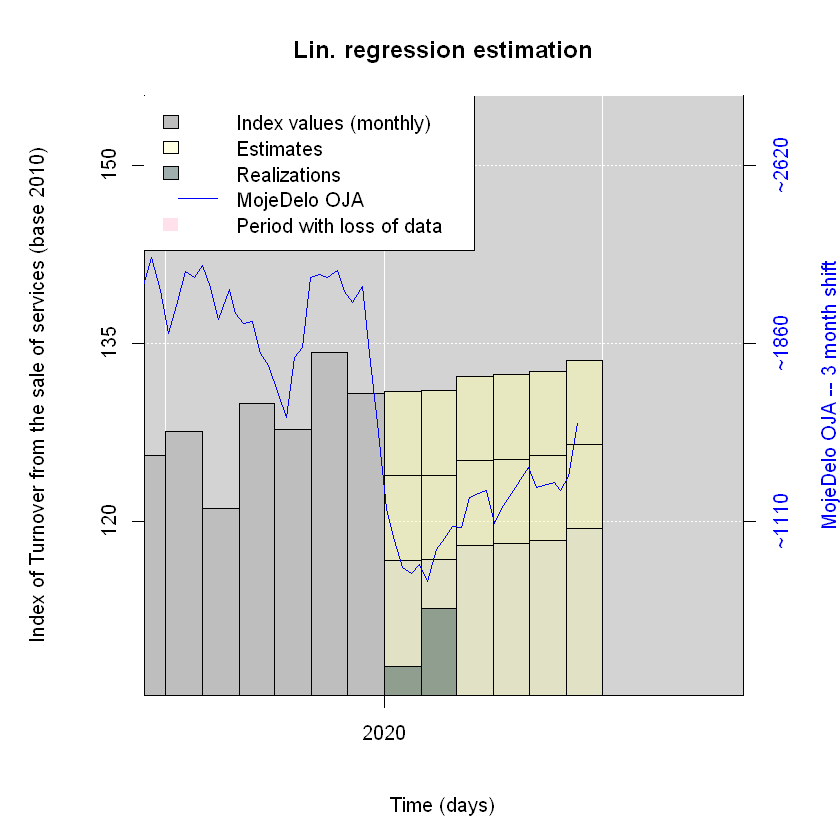

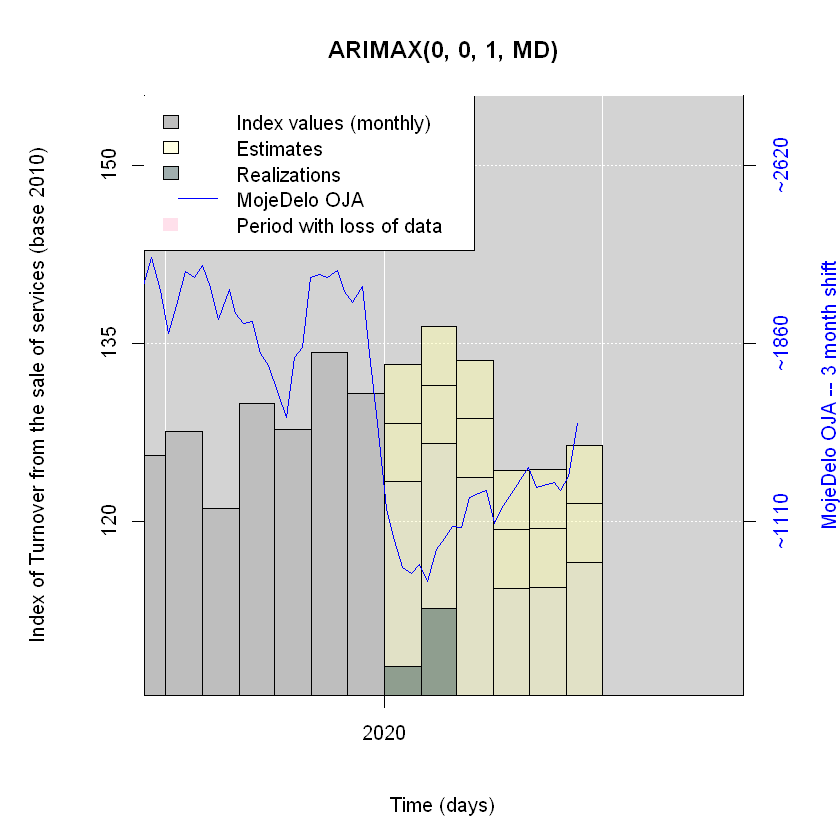

In [15]:
res = analyze_shifted(3, 882)

In [16]:
res

$cor_ind
  mJAs_MD   mJAs_MZ      mJAs 
0.1706763 0.1208819 0.1723925 

$models
$models$LR

Call:
lm(formula = c ~ ., data = estimation_Lag)

Coefficients:
(Intercept)           r1  
  1.178e+02    6.171e-03  


$models$ARIMAx

Call:
arimax(x = work_m, order = c(0, 0, 1), xreg = JAs_avg_lag$mJAs_MD[1:length(work_m)])

Coefficients:
         ma1  intercept    xreg
      0.5147   109.3022  0.0105
s.e.  0.1596    12.2589  0.0063

sigma^2 estimated as 40.31:  log likelihood = -114.51,  aic = 235.01


$stat
$stat$RMSE
[1] 7.113994

$stat$s.e.
[1] 6.348663



## Using new data for training

We also check models with newer data incorporated. We will check some models and compare AIC and LLH criteria.

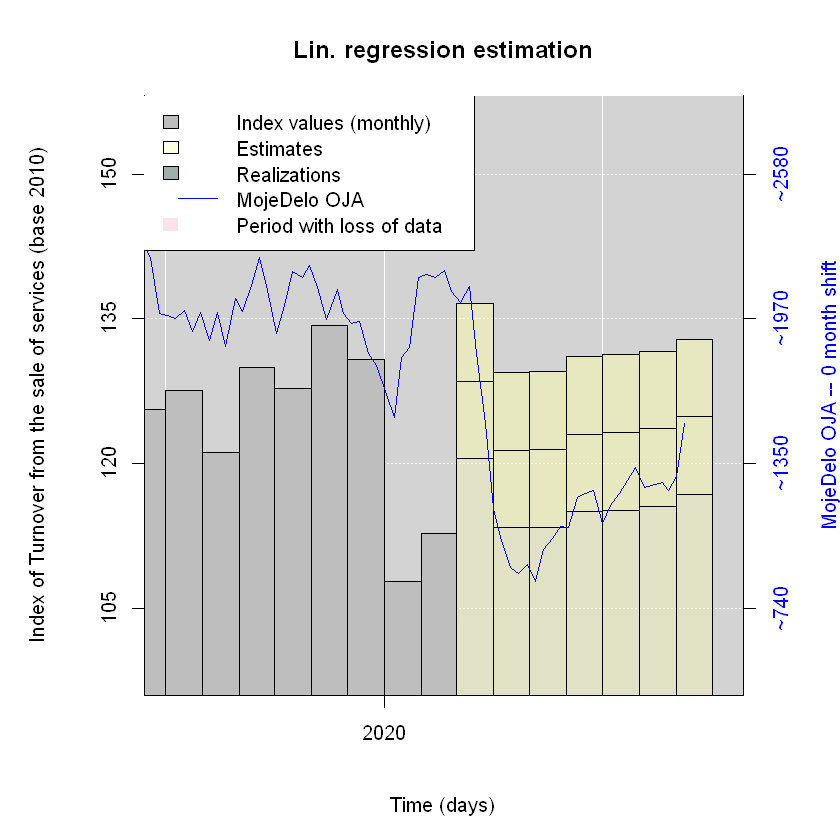

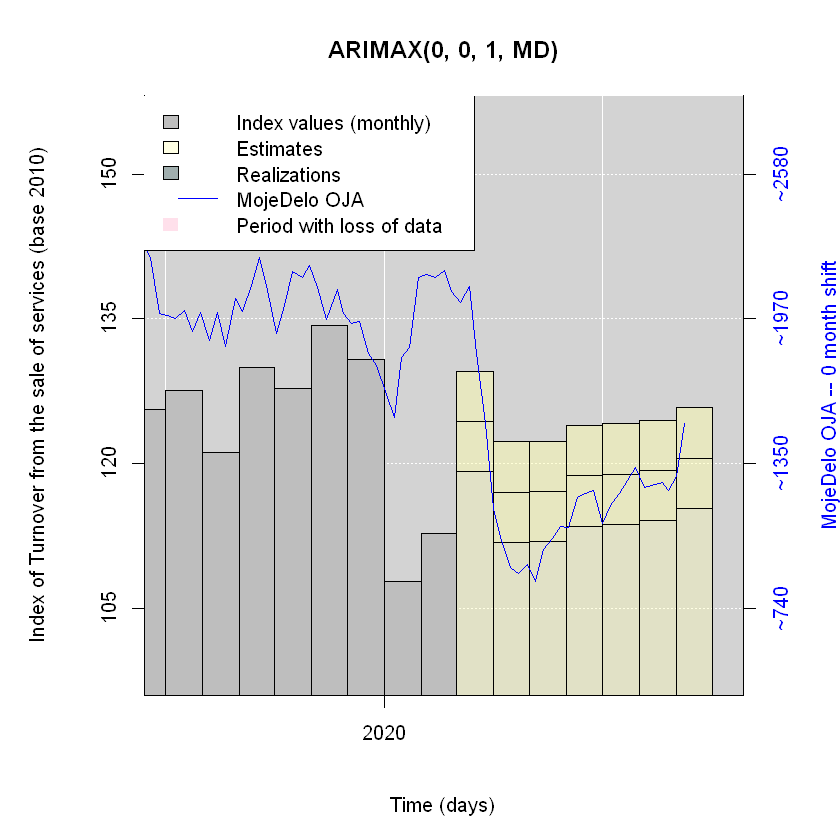

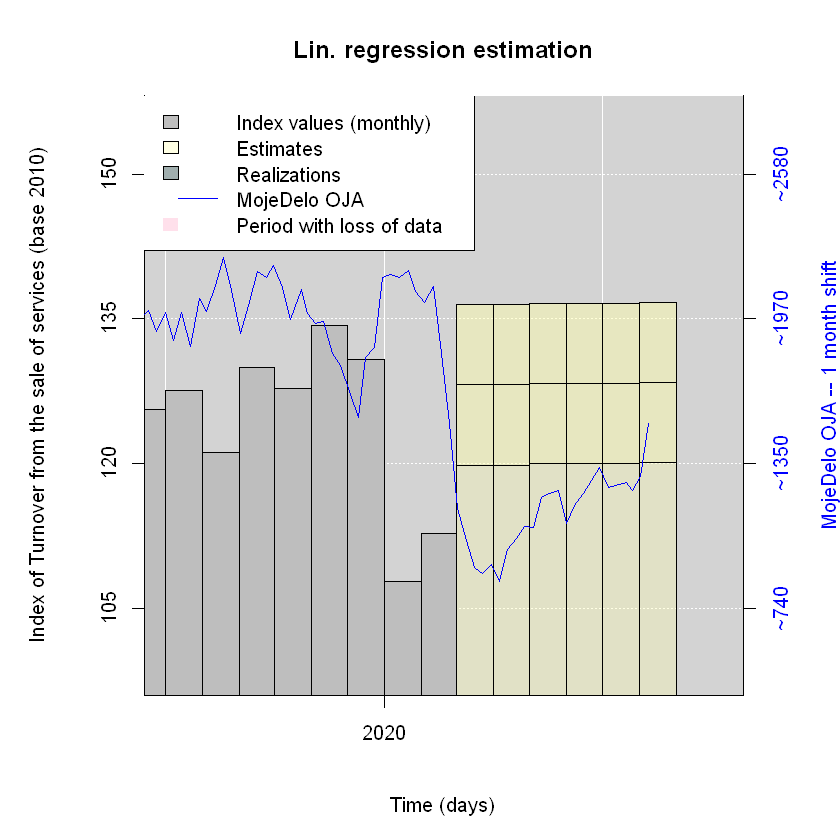

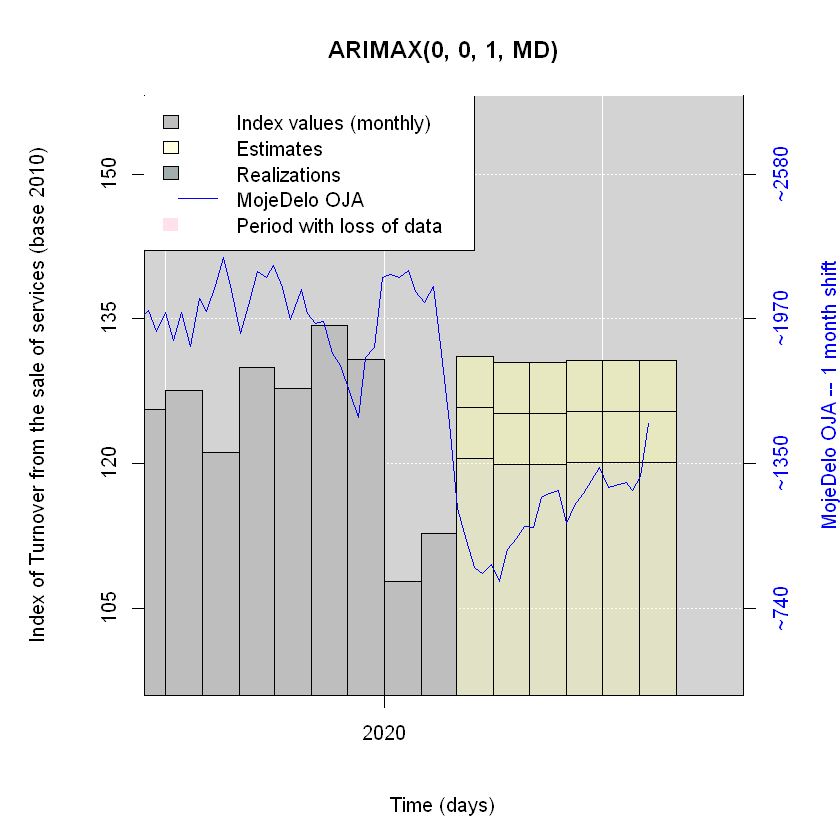

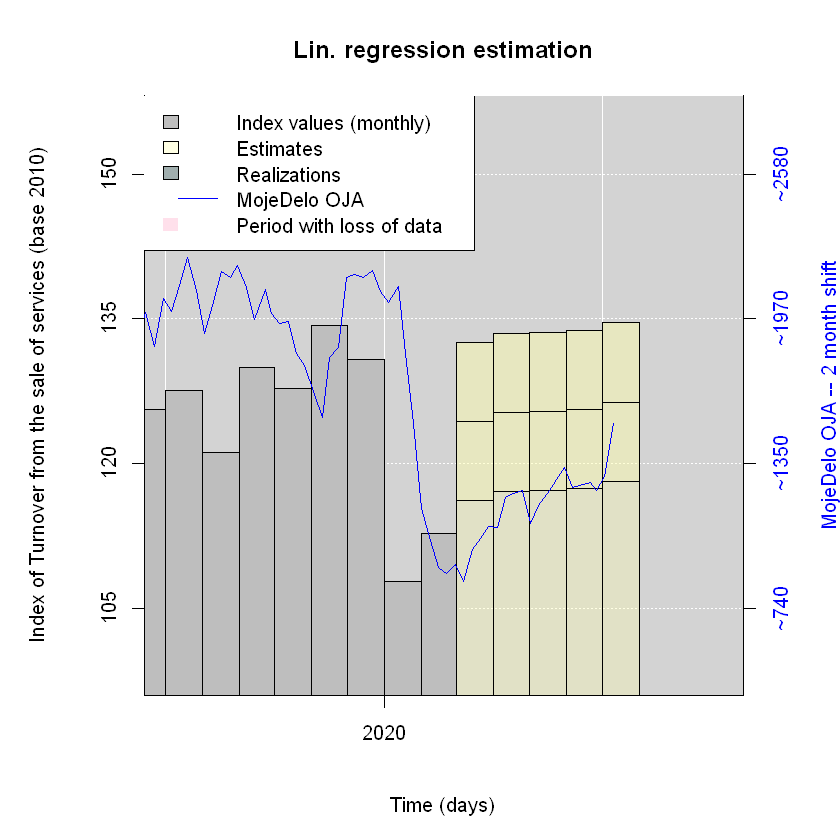

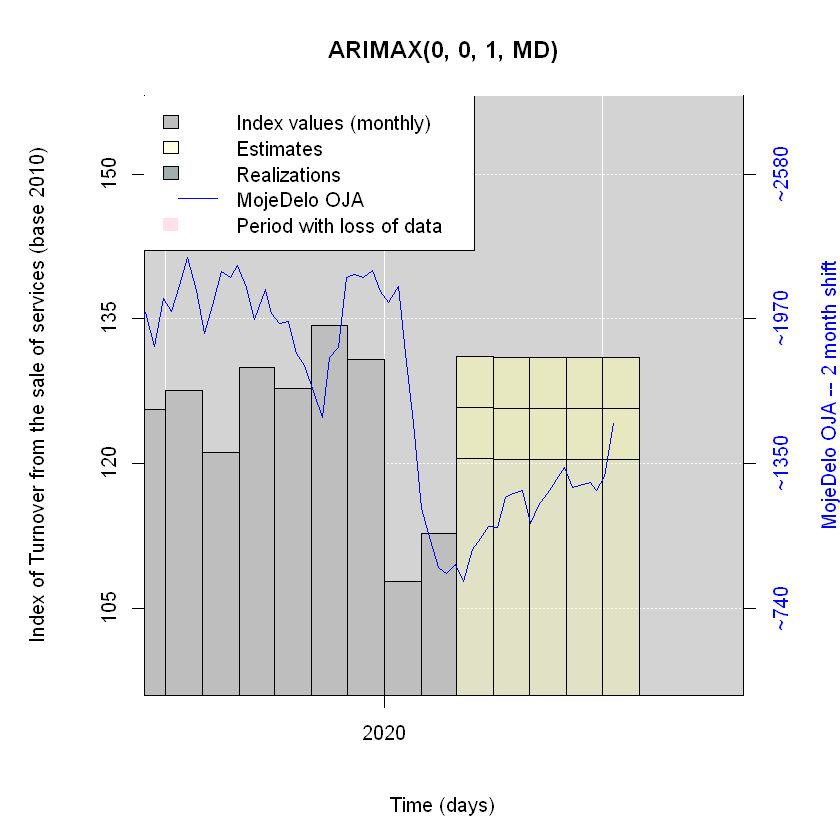

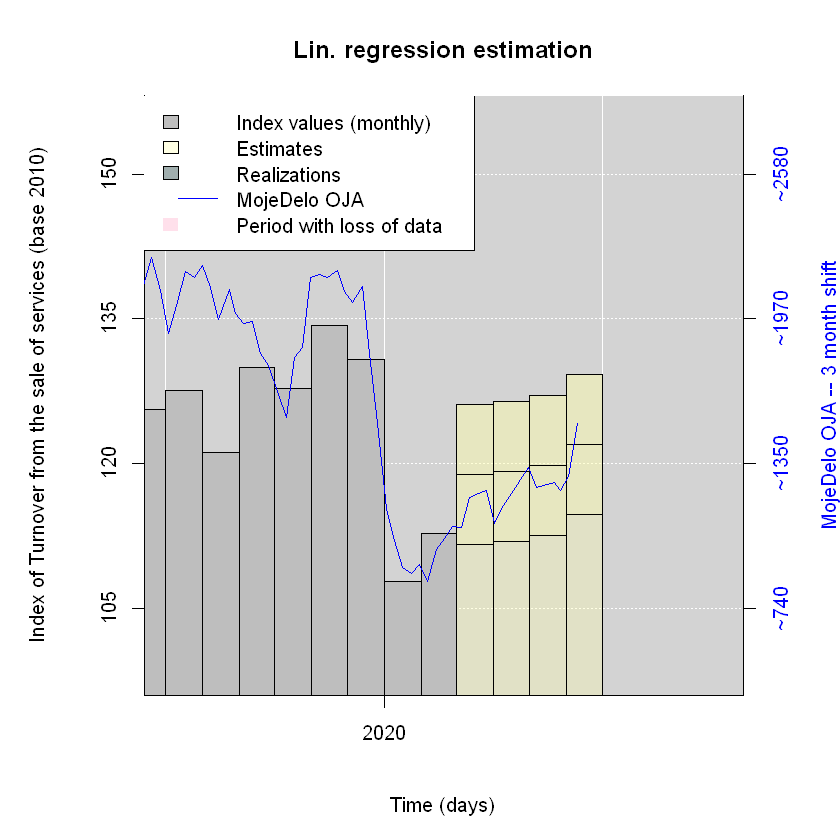

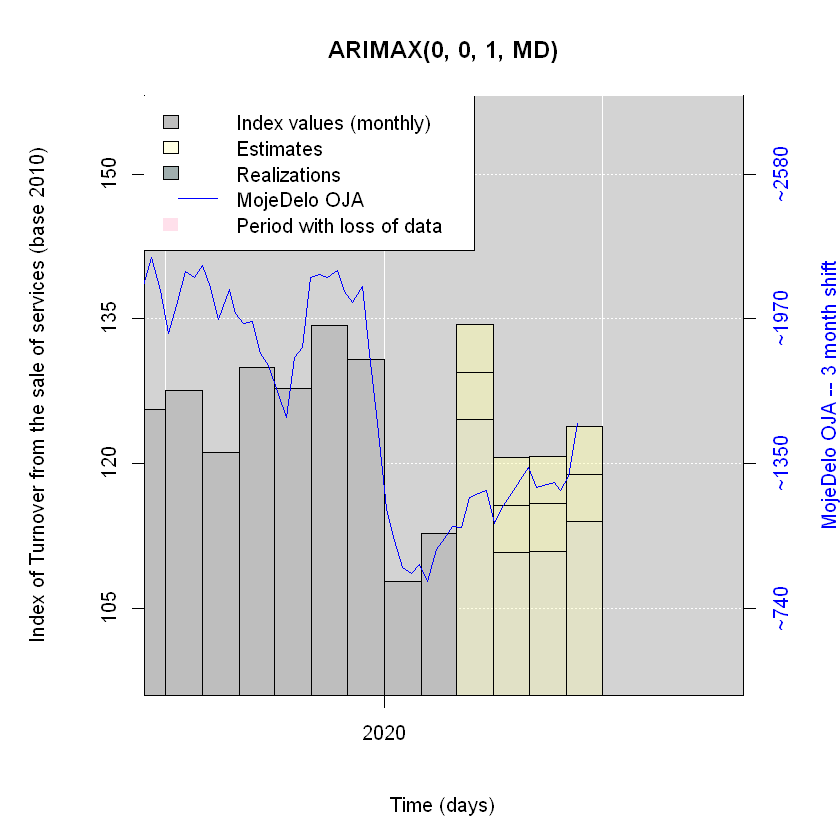

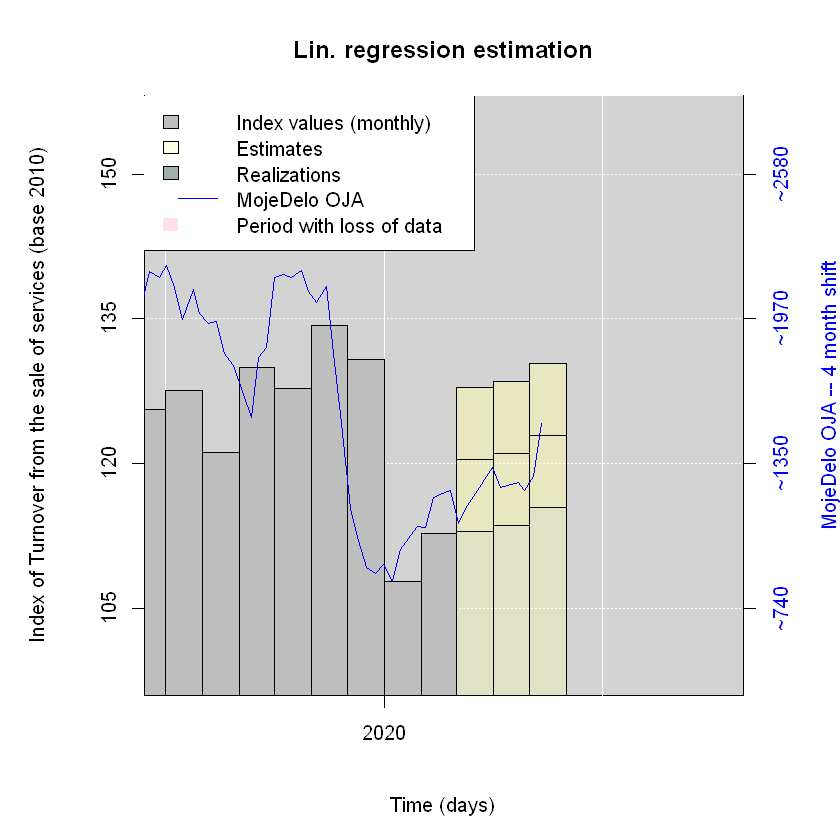

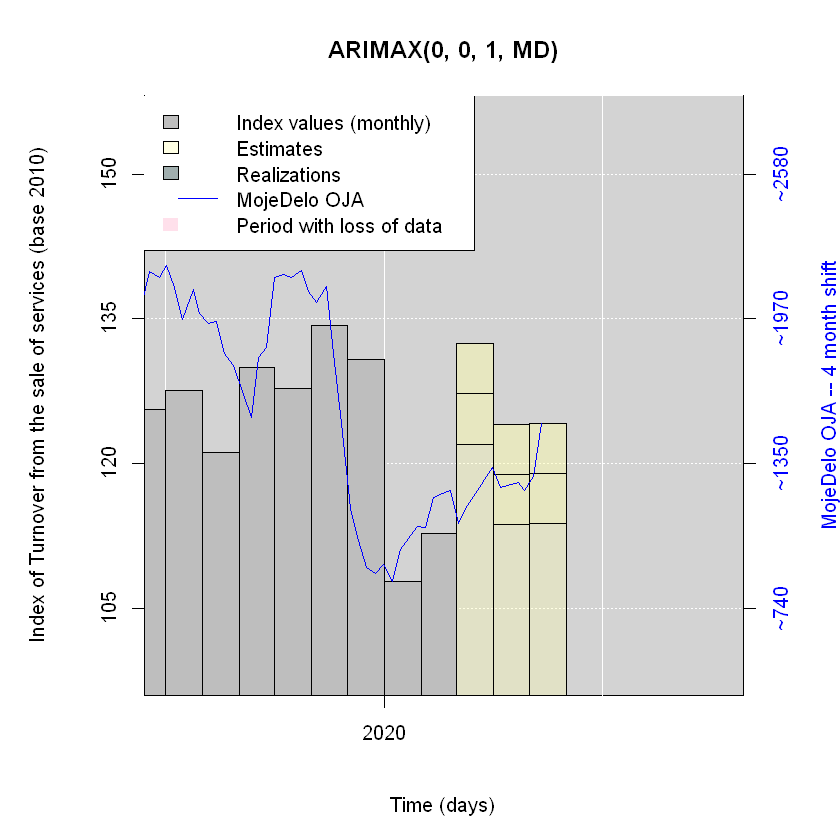

In [30]:
# We create a longer data series, by adding additional data.
work_m <- c(work_m, work_est)
res0 = analyze_shifted(0, 882, F)
res1 = analyze_shifted(1, 882, F)
res2 = analyze_shifted(2, 882, F)
res3 = analyze_shifted(3, 882, F)
res4 = analyze_shifted(4, 882, F)

# To preserve the original data, we take away the added values
work_m <- head(work_m, -length(work_est))

In [19]:
res3

$cor_ind
  mJAs_MD   mJAs_MZ      mJAs 
0.4917798 0.4221064 0.4966504 

$models
$models$LR

Call:
lm(formula = c ~ ., data = estimation_Lag)

Coefficients:
(Intercept)           r1  
  102.13285      0.01408  


$models$ARIMAx

Call:
arimax(x = work_m, order = c(0, 0, 1), xreg = JAs_avg_lag$mJAs_MD[1:length(work_m)])

Coefficients:
         ma1  intercept    xreg
      0.5725    99.4231  0.0155
s.e.  0.1647     8.5830  0.0045

sigma^2 estimated as 40.11:  log likelihood = -120.99,  aic = 247.99


$stat
$stat$RMSE
[1] 7.241414

$stat$s.e.
[1] 6.333183

